In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.graph_objects as go
import datetime


In [5]:
ticker = "aw9u.SI"
start_date = "2015-01-01"
end_date = "2025-03-16"

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [6]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AW9U.SI,AW9U.SI,AW9U.SI,AW9U.SI,AW9U.SI,AW9U.SI
Date,,,,,,
2015-01-02,0.498274,1.145454,1.150000,1.136363,1.136363,199100
2015-01-05,0.498274,1.145454,1.150000,1.140909,1.145454,67100
2015-01-06,0.496297,1.140909,1.145454,1.131818,1.140909,353100
2015-01-07,0.498274,1.145454,1.159090,1.140909,1.145454,242000
2015-01-08,0.506183,1.163636,1.168181,1.150000,1.150000,515900
...,...,...,...,...,...,...
2025-03-10,0.265000,0.265000,0.265000,0.260000,0.260000,389800
2025-03-11,0.260000,0.260000,0.260000,0.255000,0.260000,3065400


In [7]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

In [8]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,0.498274,1.145454,1.150000,1.136363,1.136363,199100
2015-01-05,0.498274,1.145454,1.150000,1.140909,1.145454,67100
2015-01-06,0.496297,1.140909,1.145454,1.131818,1.140909,353100
2015-01-07,0.498274,1.145454,1.159090,1.140909,1.145454,242000
2015-01-08,0.506183,1.163636,1.168181,1.150000,1.150000,515900
...,...,...,...,...,...,...
2025-03-10,0.265000,0.265000,0.265000,0.260000,0.260000,389800
2025-03-11,0.260000,0.260000,0.260000,0.255000,0.260000,3065400
2025-03-12,0.265000,0.265000,0.265000,0.255000,0.255000,2820200


In [9]:
df = df.rename(columns={'Close': 'GT'})
df

Price,Adj Close,GT,High,Low,Open,Volume
Date,,,,,,
2015-01-02,0.498274,1.145454,1.150000,1.136363,1.136363,199100
2015-01-05,0.498274,1.145454,1.150000,1.140909,1.145454,67100
2015-01-06,0.496297,1.140909,1.145454,1.131818,1.140909,353100
2015-01-07,0.498274,1.145454,1.159090,1.140909,1.145454,242000
2015-01-08,0.506183,1.163636,1.168181,1.150000,1.150000,515900
...,...,...,...,...,...,...
2025-03-10,0.265000,0.265000,0.265000,0.260000,0.260000,389800
2025-03-11,0.260000,0.260000,0.260000,0.255000,0.260000,3065400
2025-03-12,0.265000,0.265000,0.265000,0.255000,0.255000,2820200


In [10]:
print(df['GT'].dtypes)
print(df['GT'].describe())


float64
count    2561.000000
mean        0.722778
std         0.428304
min         0.200000
25%         0.265000
50%         0.890909
75%         1.168181
max         1.336363
Name: GT, dtype: float64


### Visualize Data

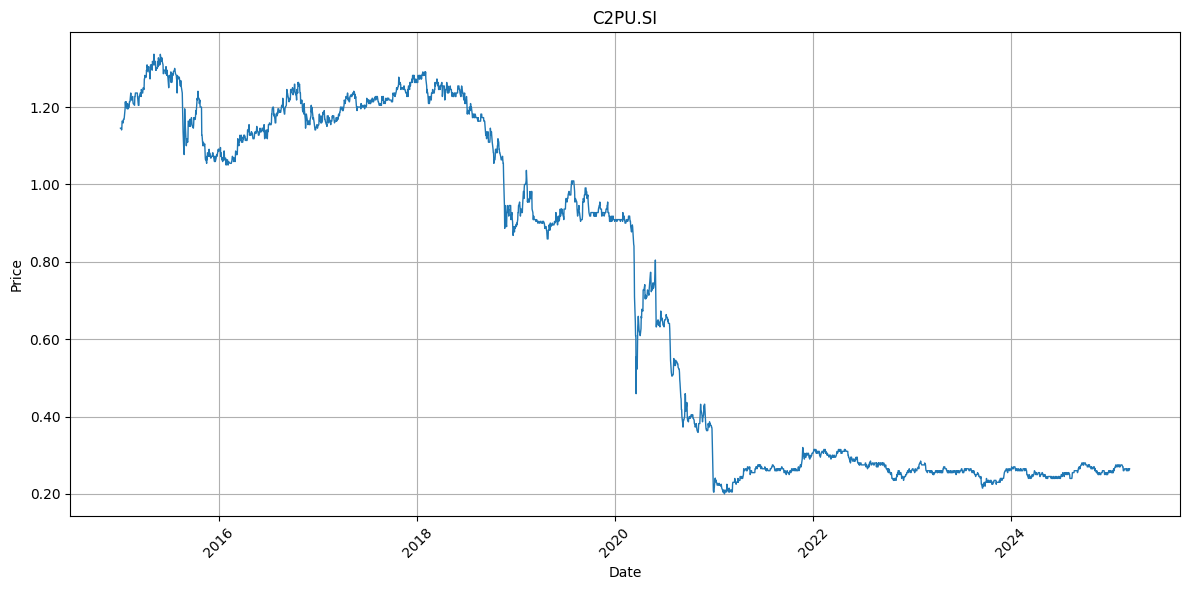

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['GT'], linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('C2PU.SI')

# Format y-axis ticks to 2 decimal places
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# Automatically reduce number of y-axis ticks (matplotlib does it smartly)
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=8))  # Limit to ~8 y-axis ticks

# Rotate x-axis ticks to avoid overlap
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Standardize data 

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(df['GT'].values.reshape(-1,1))
scaled_prices

array([[0.83200006],
       [0.83200006],
       [0.82800038],
       ...,
       [0.05720002],
       [0.05720002],
       [0.05720002]], shape=(2561, 1))

## Construct datasets

In [13]:
MOVING_WINDOW = 60
all_x, all_y = [], []
for i in range(len(scaled_prices) - MOVING_WINDOW):
    all_x.append(scaled_prices[i:i+MOVING_WINDOW]) #first 60 price
    all_y.append(scaled_prices[i+MOVING_WINDOW]) #61st price

all_x = np.array(all_x)
all_y = np.array(all_y)

In [14]:
all_x.shape, all_y.shape

((2501, 60, 1), (2501, 1))

## Split dataset

In [15]:
DS_SPLIT = 0.8

train_ds_size = round(all_x.shape[0] * DS_SPLIT)
train_x, train_y = all_x[:train_ds_size], all_y[:train_ds_size]
test_x, test_y = all_x[train_ds_size:], all_y[train_ds_size:]

In [16]:
train_x.shape

(2001, 60, 1)

In [17]:
train_y.shape

(2001, 1)

In [18]:
test_x.shape

(500, 60, 1)

In [19]:
test_y.shape

(500, 1)

## Construct Model

In [ ]:
'''
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_x.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()
'''

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
model.compile(optimizer='adam', loss='mean_squared_error')
'''

## Train Model

In [59]:
'''
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(train_x, train_y,
          validation_split=0.2,
          callbacks=[callback],
          epochs=200)

model.save('aw9u.keras') 
'''


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0743 - val_loss: 0.0021
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013 - val_loss: 2.7078e-04
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.3578e-04 - val_loss: 1.2299e-04
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 7.6833e-05
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.0305e-04 - val_loss: 1.5085e-04
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.8415e-04 - val_loss: 9.3736e-05
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.3841e-04 - val_loss: 6.1640e-05
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.0485e-04 - val_loss: 7.8422e-05
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.6189e-04 - val_loss: 5.6419e-05
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.5624e-04 - val_loss: 5.4969e-05
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.8823e-04 - v

In [25]:
model = load_model('aw9u.keras')
preds = model.predict(test_x)
preds

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.05076132],
       [0.04980559],
       [0.04751044],
       [0.04753598],
       [0.04642148],
       [0.04550026],
       [0.04672411],
       [0.04800891],
       [0.04880168],
       [0.05085972],
       [0.05237389],
       [0.05310565],
       [0.05329614],
       [0.05149151],
       [0.05162478],
       [0.05044354],
       [0.0511708 ],
       [0.05210117],
       [0.05100062],
       [0.05157865],
       [0.05233739],
       [0.05111057],
       [0.05161516],
       [0.05060325],
       [0.0513652 ],
       [0.05052773],
       [0.0496405 ],
       [0.05082518],
       [0.05380112],
       [0.05604463],
       [0.05893898],
       [0.0607781 ],
       [0.05979177],
       [0.05844246],
       [0.0575072 ],
       [0.0570601 ],
       [0.05520067],
       [0.05378982],
       [0.05310002],
       [0.05118038],
       [0.04977745],
       [0.05083191],
       [0.05037808],
       [0.0497578 ],
       [0.0493351 ],
       [0.05085396],
       [0.0505097 ],
       [0.049

In [26]:
preds = scaler.inverse_transform(preds) #convert back to original scale
preds

array([[0.25768328],
       [0.25659722],
       [0.2539891 ],
       [0.25401813],
       [0.25275165],
       [0.2517048 ],
       [0.25309554],
       [0.25455555],
       [0.25545642],
       [0.2577951 ],
       [0.25951576],
       [0.2603473 ],
       [0.26056376],
       [0.25851303],
       [0.2586645 ],
       [0.25732216],
       [0.2581486 ],
       [0.25920585],
       [0.25795522],
       [0.25861207],
       [0.25947428],
       [0.25808015],
       [0.25865355],
       [0.25750366],
       [0.25836954],
       [0.25741786],
       [0.25640965],
       [0.25775585],
       [0.2611376 ],
       [0.26368704],
       [0.2669761 ],
       [0.269066  ],
       [0.26794514],
       [0.26641187],
       [0.26534906],
       [0.264841  ],
       [0.262728  ],
       [0.26112476],
       [0.2603409 ],
       [0.2581595 ],
       [0.25656527],
       [0.2577635 ],
       [0.25724778],
       [0.25654292],
       [0.2560626 ],
       [0.25778857],
       [0.25739735],
       [0.256

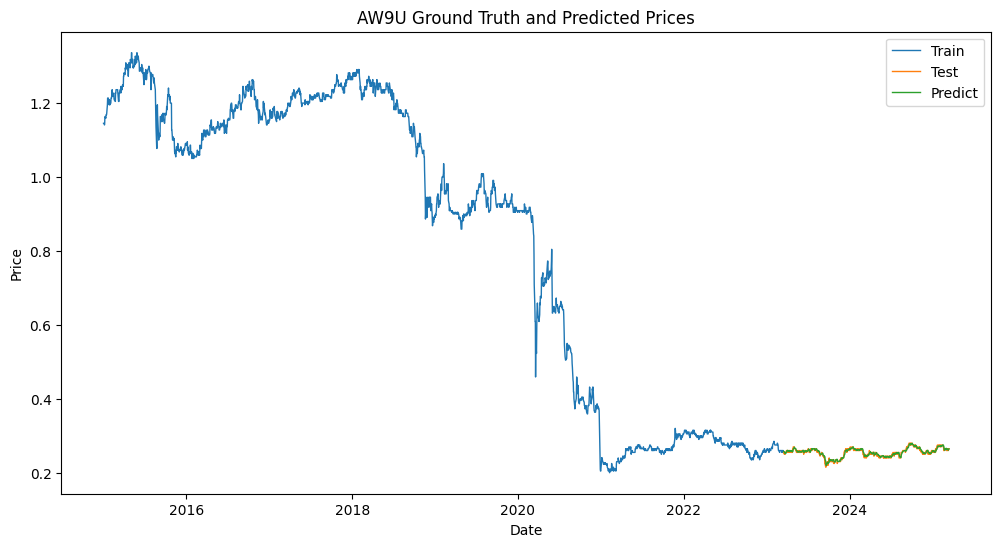

In [27]:
train_df = df[:train_ds_size+MOVING_WINDOW]
test_df = df[train_ds_size+MOVING_WINDOW:]
test_df = test_df.assign(Predict = preds)

plt.figure(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_df["GT"], linewidth=1)
plt.plot(test_df["GT"], linewidth=1)
plt.plot(test_df["Predict"], linewidth=1)
plt.legend(["Train", "Test", "Predict"])
plt.title("AW9U Ground Truth and Predicted Prices")
plt.show()

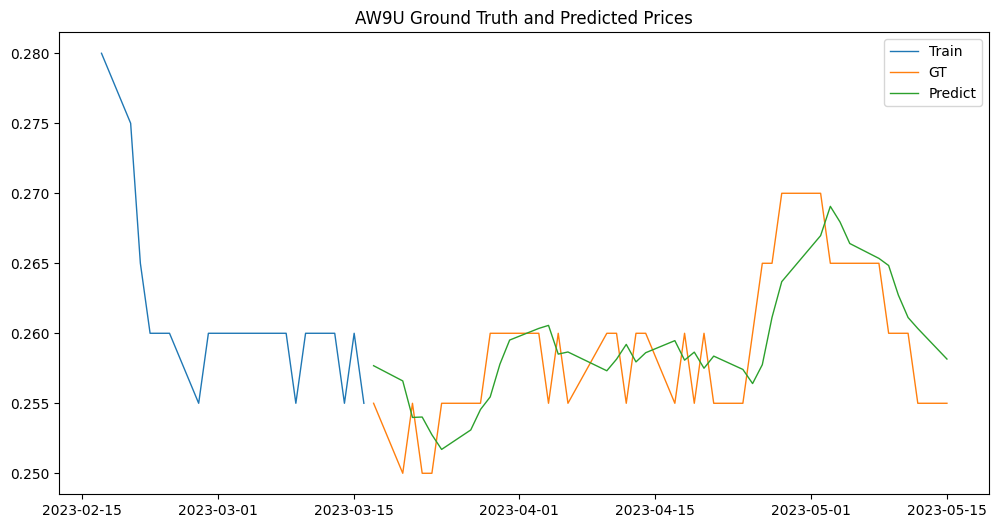

In [28]:
#zoom in
plt.figure(figsize=(12, 6))
plt.plot(train_df["GT"][-20:], linewidth=1)
plt.plot(test_df["GT"][:40], linewidth=1)
plt.plot(test_df["Predict"][:40], linewidth=1)
plt.legend(["Train", "GT", "Predict"])
plt.legend(["Train", "GT", "Predict"])
plt.title("AW9U Ground Truth and Predicted Prices")
plt.show()

In [55]:
y_true = test_df["GT"]
y_pred = test_df["Predict"]

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.6f}")

Mean Absolute Error (MAE): 0.003202
Mean Squared Error (MSE): 0.000016
Root Mean Squared Error (RMSE): 0.004021
R-squared (R²): 0.895136


In [30]:
test_df

Price,Adj Close,GT,High,Low,Open,Volume,Predict
Date,,,,,,,
2023-03-17,0.210744,0.255,0.265,0.255,0.260,2347600,0.257683
2023-03-20,0.206611,0.250,0.260,0.250,0.260,2493300,0.256597
2023-03-21,0.210744,0.255,0.260,0.250,0.255,1657300,0.253989
2023-03-22,0.206611,0.250,0.260,0.245,0.255,4499100,0.254018
2023-03-23,0.206611,0.250,0.255,0.245,0.245,1468100,0.252752
...,...,...,...,...,...,...,...
2025-03-10,0.265000,0.265,0.265,0.260,0.260,389800,0.261626
2025-03-11,0.260000,0.260,0.260,0.255,0.260,3065400,0.262777
2025-03-12,0.265000,0.265,0.265,0.255,0.255,2820200,0.262133


### Comparing one day shift to lstm predicted result

In [52]:
test_df['GT_tmr'] = test_df['GT'].shift(1)
test_df.dropna(subset=['GT_tmr'], inplace=True)

test_df

Price,Adj Close,GT,High,Low,Open,Volume,Predict,GT_tmr
Date,,,,,,,,
2023-03-20,0.206611,0.250,0.260,0.250,0.260,2493300,0.256597,0.255
2023-03-21,0.210744,0.255,0.260,0.250,0.255,1657300,0.253989,0.250
2023-03-22,0.206611,0.250,0.260,0.245,0.255,4499100,0.254018,0.255
2023-03-23,0.206611,0.250,0.255,0.245,0.245,1468100,0.252752,0.250
2023-03-24,0.210744,0.255,0.260,0.250,0.250,2173100,0.251705,0.250
...,...,...,...,...,...,...,...,...
2025-03-05,0.265000,0.265,0.265,0.260,0.265,278300,0.263912,0.265
2025-03-06,0.260000,0.260,0.265,0.260,0.265,804000,0.264534,0.265
2025-03-07,0.260000,0.260,0.265,0.260,0.260,486800,0.263040,0.260


In [54]:
results = {}

# Loop through the prediction columns
for col in ["Predict", "GT_tmr"]:
    y_true = test_df["GT"]
    y_pred = test_df[col]

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    results[col] = [mae, mse, rmse, r2]

# Convert to DataFrame for a clean display
metrics_df = pd.DataFrame(results, index=["MAE", "MSE", "RMSE", "R2"])
print(metrics_df)

       Predict    GT_tmr
MAE   0.003202  0.002792
MSE   0.000016  0.000016
RMSE  0.004021  0.003997
R2    0.895136  0.896383


## Next-Day Predictive Trading Strategy

In [32]:
# Parameters
initial_capital = 10000
percent_of_equity = 0.8
stop_loss = 0.1  # 10%
capital = initial_capital
position = None  # Current position: 'long', 'short', or None
entry_price = 0  # Price at which the position was entered
equity = initial_capital  # Track equity over time
trade_log = []  # To log trades

# Iterate through the DataFrame
for i in range(1, len(test_df) - 1):  # Ensure we don't go out of bounds for the next day's prediction
    current_price = test_df['GT'].iloc[i]  # Ground truth price for the current day
    next_predicted_price = test_df['Predict'].iloc[i + 1]  # Predicted price for the next day
    date = test_df.index[i]  # Access the date from the index

    # Check if a position is active
    if position == 'long':
        # Check for stop-loss or trend reversal
        if current_price <= entry_price * (1 - stop_loss) or next_predicted_price < current_price:
            # Close long position
            profit = (current_price - entry_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({'Date': date, 'Action': 'Close Long', 'Price': current_price, 'Profit': profit, 'Equity': equity})
            position = None

    elif position == 'short':
        # Check for stop-loss or trend reversal
        if current_price >= entry_price * (1 + stop_loss) or next_predicted_price > current_price:
            # Close short position
            profit = (entry_price - current_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({'Date': date, 'Action': 'Close Short', 'Price': current_price, 'Profit': profit, 'Equity': equity})
            position = None

    # If no position is active, check for entry signals
    if position is None:
        if next_predicted_price > current_price:
            # Open long position
            entry_price = current_price
            position = 'long'
            trade_log.append({'Date': date, 'Action': 'Open Long', 'Price': current_price, 'Profit': 0, 'Equity': equity})
        elif next_predicted_price < current_price:
            # Open short position
            entry_price = current_price
            position = 'short'
            trade_log.append({'Date': date, 'Action': 'Open Short', 'Price': current_price, 'Profit': 0, 'Equity': equity})

# Convert trade log to a DataFrame for analysis
trade_log_df = pd.DataFrame(trade_log)

# Calculate metrics
closed_trades = trade_log_df[trade_log_df['Action'].str.contains('Close')]  # Only closed trades
gross_profit = closed_trades[closed_trades['Profit'] > 0]['Profit'].sum()  # Sum of positive profits
gross_loss = closed_trades[closed_trades['Profit'] < 0]['Profit'].sum()  # Sum of negative profits
net_profit = gross_profit + gross_loss  # Net profit (gross profit + gross loss)

# Buy-and-Hold Return
initial_price = test_df['GT'].iloc[0]  # First ground truth price
final_price = test_df['GT'].iloc[-1]  # Last ground truth price
buy_and_hold_return = ((final_price - initial_price) / initial_price) * 100  # Percentage return

# Display results
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Net Profit: ${net_profit:.2f}")
print(f"Buy-and-Hold Return: {buy_and_hold_return:.2f}%")

# Display the trade log
print(trade_log_df)

# Final equity
print(f"Final Equity: ${equity:.2f}")

Gross Profit: $23453.80
Gross Loss: $-4454.43
Net Profit: $18999.37
Buy-and-Hold Return: 3.92%
          Date       Action  Price      Profit        Equity
0   2023-03-20    Open Long  0.250    0.000000  10000.000000
1   2023-03-21   Close Long  0.255  159.999847  10159.999847
2   2023-03-21   Open Short  0.255    0.000000  10159.999847
3   2023-03-22  Close Short  0.250  156.862598  10316.862446
4   2023-03-22    Open Long  0.250    0.000000  10316.862446
..         ...          ...    ...         ...           ...
424 2025-03-10   Open Short  0.265    0.000000  28694.580179
425 2025-03-11  Close Short  0.260  150.943260  28845.523440
426 2025-03-11    Open Long  0.260    0.000000  28845.523440
427 2025-03-12   Close Long  0.265  153.846013  28999.369452
428 2025-03-12   Open Short  0.265    0.000000  28999.369452

[429 rows x 5 columns]
Final Equity: $28999.37


In [33]:
# Extract series
dates = test_df.index
gt = test_df['GT']
predict = test_df['Predict']

# Separate long/short entries & exits from the trade log
entry_long = trade_log_df[trade_log_df['Action'].str.contains("Open Long")]
entry_short = trade_log_df[trade_log_df['Action'].str.contains("Open Short")]
exit_long = trade_log_df[trade_log_df['Action'].str.contains("Close Long")]
exit_short = trade_log_df[trade_log_df['Action'].str.contains("Close Short")]

# Create the interactive plot
fig = go.Figure()

# Ground truth price line
fig.add_trace(go.Scatter(x=dates, y=gt, mode='lines', name='GT (Actual)', line=dict(color='blue')))

# Predicted price line
fig.add_trace(go.Scatter(x=dates, y=predict, mode='lines', name='Predicted', line=dict(color='orange')))

# Entry Long signals
fig.add_trace(go.Scatter(
    x=entry_long['Date'], y=entry_long['Price'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Entry Short signals
fig.add_trace(go.Scatter(
    x=entry_short['Date'], y=entry_short['Price'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# Exit Long signals
fig.add_trace(go.Scatter(
    x=exit_long['Date'], y=exit_long['Price'],
    mode='markers',
    name='Exit Long',
    marker=dict(symbol='x', size=9, color='lime')
))

# Exit Short signals
fig.add_trace(go.Scatter(
    x=exit_short['Date'], y=exit_short['Price'],
    mode='markers',
    name='Exit Short',
    marker=dict(symbol='x', size=9, color='purple')
))

# Layout settings
fig.update_layout(
    title='Next-Day Predictive Trading Strategy',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white',
    hovermode='closest'
)

fig.show()


## Append news analysis result

In [34]:
sentiment_df = pd.read_csv('../news_analysis_code/c2pu_news_data.csv', usecols=['date', 'sentiment', 'sentiment_score'])
sentiment_df.columns = ['Date', 'Sentiment', 'Sentiment Score']
sentiment_df.head()

,Date,Sentiment,Sentiment Score
0,2025-01-20,neutral,0.919198
1,2025-01-09,positive,0.917262
2,2024-10-24,neutral,0.884515
3,2025-02-19,negative,0.965119
4,2024-10-23,positive,0.725505


In [35]:
sentiment_df['Sentiment'] = sentiment_df['Sentiment'].replace({
    'neutral': 0,
    'positive': 1,
    'negative': -1
})

sentiment_df.head()

C:\Users\Jesus\AppData\Local\Temp\ipykernel_5064\1101630648.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Date,Sentiment,Sentiment Score
0,2025-01-20,0,0.919198
1,2025-01-09,1,0.917262
2,2024-10-24,0,0.884515
3,2025-02-19,-1,0.965119
4,2024-10-23,1,0.725505


In [36]:
# rearrange the date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Keep only the row with the highest sentiment score
sentiment_df = sentiment_df.loc[sentiment_df.groupby('Date')['Sentiment Score'].idxmax()].reset_index(drop=True)

sentiment_df.head()

,Date,Sentiment,Sentiment Score
0,2014-10-19,0,0.559315
1,2016-09-26,1,0.941234
2,2018-03-01,0,0.899242
3,2019-07-31,1,0.951653
4,2019-11-11,0,0.725825


In [37]:
sentiment_df.dtypes

Date               datetime64[ns]
Sentiment                   int64
Sentiment Score           float64
dtype: object

In [38]:
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df = sentiment_df.set_index('Date')

In [39]:
#keep only matching dates
merged_df = pd.merge(test_df, sentiment_df, on='Date', how='left')
merged_df.head()

,Adj Close,GT,High,Low,Open,Volume,Predict,Sentiment,Sentiment Score
Date,,,,,,,,,
2023-03-17,0.210744,0.255,0.265,0.255,0.260,2347600,0.257683,NaN,NaN
2023-03-20,0.206611,0.250,0.260,0.250,0.260,2493300,0.256597,NaN,NaN
2023-03-21,0.210744,0.255,0.260,0.250,0.255,1657300,0.253989,NaN,NaN
2023-03-22,0.206611,0.250,0.260,0.245,0.255,4499100,0.254018,NaN,NaN
2023-03-23,0.206611,0.250,0.255,0.245,0.245,1468100,0.252752,NaN,NaN


In [40]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2023-03-17 to 2025-03-14
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Adj Close        500 non-null    float64
 1   GT               500 non-null    float64
 2   High             500 non-null    float64
 3   Low              500 non-null    float64
 4   Open             500 non-null    float64
 5   Volume           500 non-null    int64  
 6   Predict          500 non-null    float32
 7   Sentiment        66 non-null     float64
 8   Sentiment Score  66 non-null     float64
dtypes: float32(1), float64(7), int64(1)
memory usage: 37.1 KB


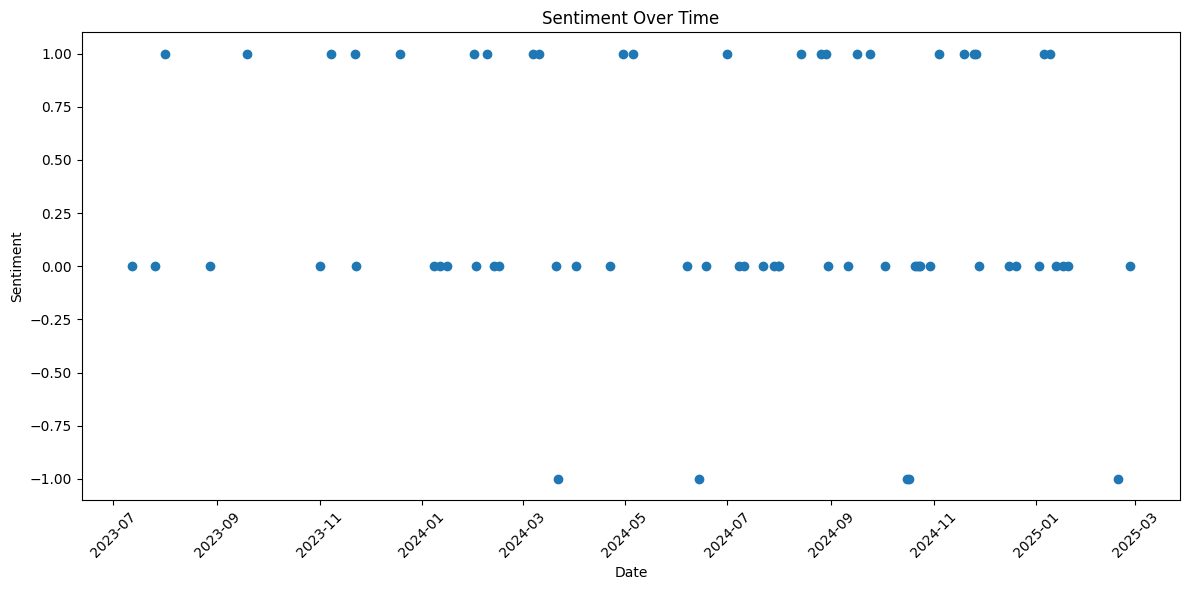

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Sentiment'], marker='o', linestyle='None')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

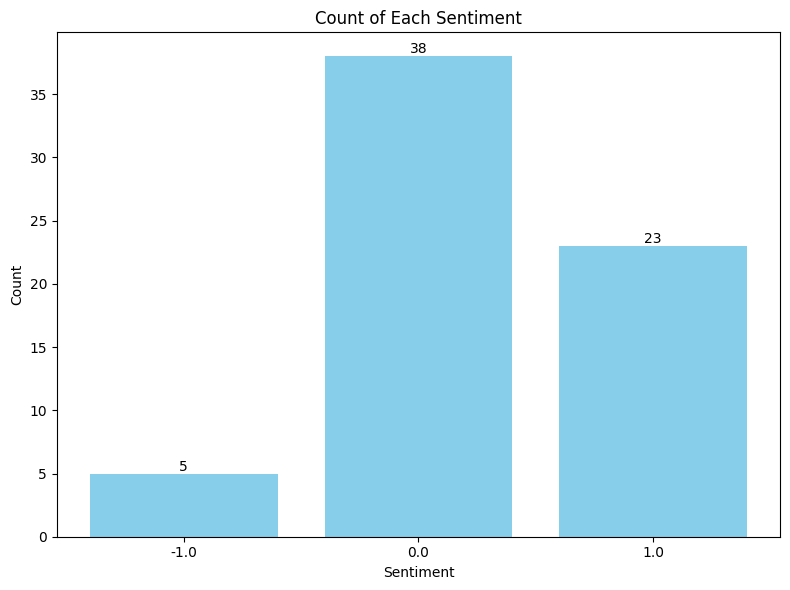

In [42]:
sentiment_counts = merged_df['Sentiment'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
bars = plt.bar(sentiment_counts.index.astype(str), sentiment_counts.values, color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Each Sentiment')

# Add the count above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [43]:
nan_count = merged_df['Sentiment'].isna().sum()
nan_count

np.int64(434)

In [44]:
merged_df

,Adj Close,GT,High,Low,Open,Volume,Predict,Sentiment,Sentiment Score
Date,,,,,,,,,
2023-03-17,0.210744,0.255,0.265,0.255,0.260,2347600,0.257683,NaN,NaN
2023-03-20,0.206611,0.250,0.260,0.250,0.260,2493300,0.256597,NaN,NaN
2023-03-21,0.210744,0.255,0.260,0.250,0.255,1657300,0.253989,NaN,NaN
2023-03-22,0.206611,0.250,0.260,0.245,0.255,4499100,0.254018,NaN,NaN
2023-03-23,0.206611,0.250,0.255,0.245,0.245,1468100,0.252752,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-03-10,0.265000,0.265,0.265,0.260,0.260,389800,0.261626,NaN,NaN
2025-03-11,0.260000,0.260,0.260,0.255,0.260,3065400,0.262777,NaN,NaN
2025-03-12,0.265000,0.265,0.265,0.255,0.255,2820200,0.262133,NaN,NaN


## News-Driven Next-Day Predictive Trading Strategy

In [45]:

initial_capital = 10000
percent_of_equity = 0.8
stop_loss = 0.2

capital = initial_capital
equity = initial_capital
trade_log = []
position = None
entry_price = None

i = 0
while i < len(test_df):
    # Forced exit condition on March 14, 2025
    if merged_df.index[i] == pd.Timestamp("2025-03-14"):
        if position is not None:
            exec_price = test_df['GT'].iloc[i]
            if position == 'long':
                profit = (exec_price - entry_price) * (capital * percent_of_equity / entry_price)
                trade_log.append({
                    'Date': test_df.index[i],
                    'Action': 'Forced Exit Long',
                    'Price': exec_price,
                    'Profit': profit,
                    'Equity': equity
                })
            elif position == 'short':
                profit = (entry_price - exec_price) * (capital * percent_of_equity / entry_price)
                trade_log.append({
                    'Date': test_df.index[i],
                    'Action': 'Forced Exit Short',
                    'Price': exec_price,
                    'Profit': profit,
                    'Equity': equity
                })
        break

    signal_price = merged_df['GT'].iloc[i]
    predicted_price = merged_df['Predict'].iloc[i]

    # Entry signals (same day)
    if position is None:
        if predicted_price > signal_price and (merged_df['Sentiment'].iloc[i] in [1, 0] or pd.isna(merged_df['Sentiment'].iloc[i])):
            position = 'long'
            entry_price = merged_df['GT'].iloc[i]
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Enter Long',
                'Price': entry_price,
                'Profit': 0,
                'Equity': equity
            })
        elif predicted_price < signal_price and (merged_df['Sentiment'].iloc[i] in [-1, 0] or pd.isna(merged_df['Sentiment'].iloc[i])):
            position = 'short'
            entry_price = merged_df['GT'].iloc[i]
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Enter Short',
                'Price': entry_price,
                'Profit': 0,
                'Equity': equity
            })
        i += 1
        continue

    # Exit conditions (same day)
    current_gt = merged_df['GT'].iloc[i]
    if position == 'long':
        if predicted_price < current_gt or current_gt <= entry_price * (1 - stop_loss) or merged_df['Sentiment'].iloc[i] == -1:
            profit = (current_gt - entry_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Exit Long',
                'Price': current_gt,
                'Profit': profit,
                'Equity': equity
            })
            position = None
    elif position == 'short':
        if predicted_price > current_gt or current_gt >= entry_price * (1 + stop_loss) or merged_df['Sentiment'].iloc[i] == 1:
            profit = (entry_price - current_gt) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Exit Short',
                'Price': current_gt,
                'Profit': profit,
                'Equity': equity
            })
            position = None
    i += 1

# Create DataFrame from trade log
trade_log_df = pd.DataFrame(trade_log)

# Summary metrics
closed_trades = trade_log_df[trade_log_df['Action'].str.contains('Exit')]
gross_profit = closed_trades[closed_trades['Profit'] > 0]['Profit'].sum()
gross_loss = closed_trades[closed_trades['Profit'] < 0]['Profit'].sum()
net_profit = gross_profit + gross_loss
buy_and_hold_return = ((test_df['GT'].iloc[-1] - test_df['GT'].iloc[0]) / test_df['GT'].iloc[0]) * 100

print(f"\n--- Strategy Summary ---")
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Net Profit: ${net_profit:.2f}")
print(f"Buy-and-Hold Return: {buy_and_hold_return:.2f}%")
print(f"Final Equity: ${equity:.2f}")
print("\nTrade Log:")
print(trade_log_df)



--- Strategy Summary ---
Gross Profit: $15303.27
Gross Loss: $-3153.00
Net Profit: $12150.27
Buy-and-Hold Return: 3.92%
Final Equity: $22150.27

Trade Log:
          Date             Action  Price      Profit        Equity
0   2023-03-17         Enter Long  0.255    0.000000  10000.000000
1   2023-03-21          Exit Long  0.255    0.000000  10000.000000
2   2023-03-22         Enter Long  0.250    0.000000  10000.000000
3   2023-03-24          Exit Long  0.255  159.999847  10159.999847
4   2023-03-27        Enter Short  0.255    0.000000  10159.999847
..         ...                ...    ...         ...           ...
291 2025-03-10          Exit Long  0.265  153.846013  21996.428375
292 2025-03-11         Enter Long  0.260    0.000000  21996.428375
293 2025-03-12          Exit Long  0.265  153.846013  22150.274388
294 2025-03-13        Enter Short  0.265    0.000000  22150.274388
295 2025-03-14  Forced Exit Short  0.265    0.000000  22150.274388

[296 rows x 5 columns]


In [85]:
import plotly.graph_objects as go

# Extract series
dates = merged_df.index
gt = merged_df['GT']
predict = merged_df['Predict']

# Separate long/short entries & exits from the trade log
entry_long = trade_log_df[trade_log_df['Action'].str.contains("Enter Long")]
entry_short = trade_log_df[trade_log_df['Action'].str.contains("Enter Short")]
exit_long = trade_log_df[trade_log_df['Action'].str.contains("Exit Long")]
exit_short = trade_log_df[trade_log_df['Action'].str.contains("Exit Short")]

# Create the interactive plot
fig = go.Figure()

# Ground truth price line
fig.add_trace(go.Scatter(x=dates, y=gt, mode='lines', name='GT (Actual)', line=dict(color='blue')))

# Predicted price line
fig.add_trace(go.Scatter(x=dates, y=predict, mode='lines', name='Predicted', line=dict(color='orange')))

# Entry Long signals
fig.add_trace(go.Scatter(
    x=entry_long['Date'], y=entry_long['Price'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Entry Short signals
fig.add_trace(go.Scatter(
    x=entry_short['Date'], y=entry_short['Price'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# Exit Long signals
fig.add_trace(go.Scatter(
    x=exit_long['Date'], y=exit_long['Price'],
    mode='markers',
    name='Exit Long',
    marker=dict(symbol='x', size=9, color='lime')
))

# Exit Short signals
fig.add_trace(go.Scatter(
    x=exit_short['Date'], y=exit_short['Price'],
    mode='markers',
    name='Exit Short',
    marker=dict(symbol='x', size=9, color='purple')
))

# Layout settings
fig.update_layout(
    title='News-Driven Next-Day Predictive Trading Strategy',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white',
    hovermode='closest'
)

fig.show()
